In [1]:
import os
os.environ['CUDA_ENVIRONMENT_DEVICES'] = "0"

In [2]:
import sys
import numpy as np
from numpy import asarray,zeros
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import transformers
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW, get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import timm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
labels_data = np.load("../data/labels.npy").squeeze(1)
ids_data = np.load("../data/ids.npy").squeeze(1)

print(labels_data.shape)
print(ids_data.shape)

(11766,)
(11766,)


In [5]:
img_data = np.load("../data/image_array.npy")
print(img_data.shape)

(11766, 2, 224, 224, 3)


In [6]:
num_images, sources, width, height, num_channels = img_data.shape
img_data_reshape = np.reshape(img_data, newshape=(num_images, sources, num_channels, width, height))
img_data_target = img_data_reshape[:,0,:,:,:] # Don't convert to GPU
print('New Target Shape', img_data_target.shape)

New Target Shape (11766, 3, 224, 224)


# DataLoader

In [7]:
def get_data_loader(batch_size, target_data, labels, split_type = 'train'):
    target_data = torch.tensor(target_data)
    labels = torch.tensor(labels, dtype=torch.long)
    data = TensorDataset(target_data, labels)
    if split_type == 'train':
        sampler = RandomSampler(data)
    elif split_type == 'val':
        sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return data, sampler, dataloader

In [8]:
# Split data
train_target_data, test_target_data, train_ids, test_ids, train_labels, test_labels = train_test_split(img_data_target, ids_data, labels_data, test_size=0.2, random_state=43)

In [9]:
batch_size = 256
train_data, train_sampler, train_dataloader = get_data_loader(batch_size, train_target_data, train_labels, 'train')
test_data, test_sampler, test_dataloader = get_data_loader(batch_size, test_target_data, test_labels, 'val')

# Model

In [10]:
# Vision Model
class ResNetBottom(nn.Module):
    def __init__(self, original_model):
        super(ResNetBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        return x

class ImageOnly(nn.Module):
    def __init__(self):
        super(ImageOnly, self).__init__()
        self.base_resnet_18 = timm.create_model('resnet18', pretrained=True)
        self.base_image_model = ResNetBottom(self.base_resnet_18)
        self.Linear_1 = nn.Linear(512, 128, bias=True)
        self.tanh = nn.Tanh()
        self.classification_layer = nn.Linear(128, 2)
        # Freezing Base model weights
        for p in self.base_image_model.parameters():
                p.requires_grad = False
    def forward(self, img_features):
        img_hidden = self.base_image_model(img_features)
        inter_1 = self.tanh(self.Linear_1(img_hidden))
        logits = self.classification_layer(inter_1)
        return logits

In [11]:
model = ImageOnly().to(device)

In [12]:
# model(img_data_target[0:32,:,:,:].to(device)).shape

# Training

In [13]:
# Optimizer and scheduler
def get_optimizer_scheduler(name, model, train_dataloader_len, epochs, lr_set):
    optimizer = AdamW(model.parameters(),
                lr = lr_set, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
    )

    total_steps = train_dataloader_len * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = total_steps//2, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    return optimizer, scheduler

In [14]:
# Getting the optimizer and scheduler
epochs = 50
lr = 3e-5 # Less LR
# lr = 0.5
iters_to_accumulate = 2
name = "Adam"
# name = "LARS-SGD"
criterion = nn.CrossEntropyLoss()
optimizer, scheduler = get_optimizer_scheduler(name, model, len(train_dataloader), epochs, lr)

In [15]:
################ Evaluating Loss ######################
#######################################################
def evaluate_loss(net, device, criterion, dataloader):
    net.eval()
    mean_loss = 0
    count = 0
    with torch.no_grad():
        for it, (target_inputs, labels) in enumerate(tqdm(dataloader)):
            target_inputs, labels = target_inputs.to(device), labels.to(device)
            logits = net(target_inputs)
            mean_loss += criterion(logits.squeeze(-1), labels).item() # initially it was logits.squeeze(-1)
            count += 1
    return mean_loss / count

In [16]:
################ Flat Accuracy Calculation ####################
###############################################################
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
################ Validation Accuracy Calculation ####################
###############################################################
def evaluate_accuracy(model, device, validation_dataloader):
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)	    
        # Unpack the inputs from our dataloader
        b_t_inputs, b_labels = batch	    

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad(): 
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            logits = model(b_t_inputs)       

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
    accuracy = eval_accuracy/nb_eval_steps
    return accuracy

In [17]:
def train_model(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate):
    best_loss = np.Inf
    best_ep = 1
    nb_iterations = len(train_loader)
    print_every = nb_iterations // 5  # print the training loss 5 times per epoch
    iters = []
    train_losses = []
    val_losses = []
    # Iterating over all epochs
    for ep in range(epochs):
        net.train()
        running_loss = 0.0
        for it, (target_inputs, labels) in enumerate(tqdm(train_loader)):

            # Converting to cuda tensors
            target_inputs, labels = target_inputs.to(device), labels.to(device)
    		
            # Obtaining the logits from the model
            logits = net(target_inputs)
            # print(logits.device)

            # Computing loss
            # print(logits.squeeze(-1).shape)
            # print(labels.shape)
            loss = criterion(logits.squeeze(-1), labels)
            loss = loss / iters_to_accumulate  # Normalize the loss because it is averaged

            # Backpropagating the gradients
            # Calls backward()
            loss.backward()

            if (it + 1) % iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                opti.step()
                # Adjust the learning rate based on the number of iterations.
                lr_scheduler.step()
                # Clear gradients
                net.zero_grad()


            running_loss += loss.item()

            if (it + 1) % print_every == 0:  # Print training loss information
                print()
                print("Iteration {}/{} of epoch {} complete. Loss : {} "
                      .format(it+1, nb_iterations, ep+1, running_loss / print_every))

                running_loss = 0.0


        val_loss = evaluate_loss(net, device, criterion, val_loader)  # Compute validation loss
        val_losses.append(val_loss)
        val_accuracy = evaluate_accuracy(net, device, val_loader)
        print()
        print("Epoch {} complete! Validation Loss : {}".format(ep+1, val_loss))
        print("Epoch {} complete! Validation Accuracy : {}".format(ep+1, val_accuracy))

        if val_loss < best_loss:
            print("Best validation loss improved from {} to {}".format(best_loss, val_loss))
            print()
            net_copy = copy.deepcopy(net)  # save a copy of the model
            best_loss = val_loss
            best_ep = ep + 1

    # Saving the model
    path_to_model='saved_models/lr_{}_val_loss_{}_ep_{}_image_only.pt'.format(lr, round(best_loss, 5), best_ep)
    torch.save(net_copy.state_dict(), path_to_model)
    net.load_state_dict(torch.load(path_to_model)) # Re-Loading the best model
    print("The model has been saved in {}".format(path_to_model))

    del loss
    torch.cuda.empty_cache()
    return net, val_losses

In [18]:
# Train the model
model, val_losses = train_model(model, criterion, optimizer, lr, scheduler, train_dataloader, test_dataloader, epochs, iters_to_accumulate)

 19%|█▉        | 7/37 [00:02<00:09,  3.18it/s]


Iteration 7/37 of epoch 1 complete. Loss : 0.34461843967437744 


 38%|███▊      | 14/37 [00:04<00:07,  3.20it/s]


Iteration 14/37 of epoch 1 complete. Loss : 0.34286597796848844 


 57%|█████▋    | 21/37 [00:06<00:04,  3.28it/s]


Iteration 21/37 of epoch 1 complete. Loss : 0.34605024116379873 


 76%|███████▌  | 28/37 [00:08<00:02,  3.62it/s]


Iteration 28/37 of epoch 1 complete. Loss : 0.34538574729646954 


 95%|█████████▍| 35/37 [00:10<00:00,  3.36it/s]


Iteration 35/37 of epoch 1 complete. Loss : 0.3456669662679945 


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]



Epoch 1 complete! Validation Loss : 0.6925963878631591
Epoch 1 complete! Validation Accuracy : 0.5274375
Best validation loss improved from inf to 0.6925963878631591



 22%|██▏       | 8/37 [00:01<00:05,  5.16it/s]


Iteration 7/37 of epoch 2 complete. Loss : 0.34531858563423157 


 41%|████      | 15/37 [00:02<00:04,  5.26it/s]


Iteration 14/37 of epoch 2 complete. Loss : 0.3412454468863351 


 59%|█████▉    | 22/37 [00:04<00:02,  5.24it/s]


Iteration 21/37 of epoch 2 complete. Loss : 0.3448385127953121 


 78%|███████▊  | 29/37 [00:05<00:01,  5.26it/s]


Iteration 28/37 of epoch 2 complete. Loss : 0.3450909171785627 


 97%|█████████▋| 36/37 [00:06<00:00,  5.25it/s]


Iteration 35/37 of epoch 2 complete. Loss : 0.3431454130581447 


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]



Epoch 2 complete! Validation Loss : 0.6900145709514618
Epoch 2 complete! Validation Accuracy : 0.5368125
Best validation loss improved from 0.6925963878631591 to 0.6900145709514618



 19%|█▉        | 7/37 [00:01<00:06,  4.81it/s]


Iteration 7/37 of epoch 3 complete. Loss : 0.34555753214018686 


 38%|███▊      | 14/37 [00:02<00:04,  4.62it/s]


Iteration 14/37 of epoch 3 complete. Loss : 0.3393160658223288 


 57%|█████▋    | 21/37 [00:04<00:03,  4.51it/s]


Iteration 21/37 of epoch 3 complete. Loss : 0.34475223081452505 


 76%|███████▌  | 28/37 [00:05<00:01,  4.70it/s]


Iteration 28/37 of epoch 3 complete. Loss : 0.34178397059440613 


 95%|█████████▍| 35/37 [00:07<00:00,  4.83it/s]


Iteration 35/37 of epoch 3 complete. Loss : 0.3417273759841919 


100%|██████████| 10/10 [00:01<00:00,  6.03it/s]



Epoch 3 complete! Validation Loss : 0.6884062588214874
Epoch 3 complete! Validation Accuracy : 0.537546875
Best validation loss improved from 0.6900145709514618 to 0.6884062588214874



 22%|██▏       | 8/37 [00:01<00:05,  5.11it/s]


Iteration 7/37 of epoch 4 complete. Loss : 0.34176852447646006 


 41%|████      | 15/37 [00:02<00:04,  5.05it/s]


Iteration 14/37 of epoch 4 complete. Loss : 0.3420114687510899 


 59%|█████▉    | 22/37 [00:04<00:02,  5.03it/s]


Iteration 21/37 of epoch 4 complete. Loss : 0.3409822625773294 


 76%|███████▌  | 28/37 [00:05<00:01,  4.90it/s]


Iteration 28/37 of epoch 4 complete. Loss : 0.34311720728874207 


 95%|█████████▍| 35/37 [00:07<00:00,  4.79it/s]


Iteration 35/37 of epoch 4 complete. Loss : 0.34013819694519043 


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]



Epoch 4 complete! Validation Loss : 0.6868131756782532
Epoch 4 complete! Validation Accuracy : 0.5470625
Best validation loss improved from 0.6884062588214874 to 0.6868131756782532



 22%|██▏       | 8/37 [00:01<00:05,  5.29it/s]


Iteration 7/37 of epoch 5 complete. Loss : 0.34143134525844027 


 38%|███▊      | 14/37 [00:02<00:04,  4.76it/s]


Iteration 14/37 of epoch 5 complete. Loss : 0.3404840188367026 


 59%|█████▉    | 22/37 [00:04<00:02,  5.19it/s]


Iteration 21/37 of epoch 5 complete. Loss : 0.33875204409871784 


 78%|███████▊  | 29/37 [00:05<00:01,  5.38it/s]


Iteration 28/37 of epoch 5 complete. Loss : 0.34025188854762484 


 97%|█████████▋| 36/37 [00:06<00:00,  5.37it/s]


Iteration 35/37 of epoch 5 complete. Loss : 0.3421233892440796 


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]



Epoch 5 complete! Validation Loss : 0.6864651739597321
Epoch 5 complete! Validation Accuracy : 0.5564375
Best validation loss improved from 0.6868131756782532 to 0.6864651739597321



 22%|██▏       | 8/37 [00:01<00:05,  5.49it/s]


Iteration 7/37 of epoch 6 complete. Loss : 0.33880856207438875 


 41%|████      | 15/37 [00:02<00:03,  5.50it/s]


Iteration 14/37 of epoch 6 complete. Loss : 0.3397298412663596 


 59%|█████▉    | 22/37 [00:03<00:02,  5.39it/s]


Iteration 21/37 of epoch 6 complete. Loss : 0.33859454308237347 


 78%|███████▊  | 29/37 [00:05<00:01,  5.21it/s]


Iteration 28/37 of epoch 6 complete. Loss : 0.33953883392470224 


 97%|█████████▋| 36/37 [00:06<00:00,  5.61it/s]


Iteration 35/37 of epoch 6 complete. Loss : 0.33987294350351605 


100%|██████████| 10/10 [00:01<00:00,  6.94it/s]



Epoch 6 complete! Validation Loss : 0.686051881313324
Epoch 6 complete! Validation Accuracy : 0.56034375
Best validation loss improved from 0.6864651739597321 to 0.686051881313324



 22%|██▏       | 8/37 [00:01<00:05,  5.57it/s]


Iteration 7/37 of epoch 7 complete. Loss : 0.34054543716566904 


 41%|████      | 15/37 [00:02<00:03,  5.85it/s]


Iteration 14/37 of epoch 7 complete. Loss : 0.33894889269556316 


 59%|█████▉    | 22/37 [00:03<00:02,  5.82it/s]


Iteration 21/37 of epoch 7 complete. Loss : 0.34173655935696196 


 78%|███████▊  | 29/37 [00:05<00:01,  5.64it/s]


Iteration 28/37 of epoch 7 complete. Loss : 0.33654055425098967 


 97%|█████████▋| 36/37 [00:06<00:00,  5.72it/s]


Iteration 35/37 of epoch 7 complete. Loss : 0.3374503638063158 


100%|██████████| 10/10 [00:01<00:00,  6.16it/s]



Epoch 7 complete! Validation Loss : 0.6853377282619476
Epoch 7 complete! Validation Accuracy : 0.5623437499999999
Best validation loss improved from 0.686051881313324 to 0.6853377282619476



 22%|██▏       | 8/37 [00:01<00:05,  5.72it/s]


Iteration 7/37 of epoch 8 complete. Loss : 0.3413052899496896 


 41%|████      | 15/37 [00:02<00:03,  5.77it/s]


Iteration 14/37 of epoch 8 complete. Loss : 0.3392731121608189 


 59%|█████▉    | 22/37 [00:03<00:02,  5.63it/s]


Iteration 21/37 of epoch 8 complete. Loss : 0.33644535286085947 


 78%|███████▊  | 29/37 [00:05<00:01,  5.62it/s]


Iteration 28/37 of epoch 8 complete. Loss : 0.3358938523701259 


 97%|█████████▋| 36/37 [00:06<00:00,  5.60it/s]


Iteration 35/37 of epoch 8 complete. Loss : 0.3407347798347473 


100%|██████████| 10/10 [00:01<00:00,  6.28it/s]



Epoch 8 complete! Validation Loss : 0.6844667971134186
Epoch 8 complete! Validation Accuracy : 0.563515625
Best validation loss improved from 0.6853377282619476 to 0.6844667971134186



 22%|██▏       | 8/37 [00:01<00:05,  5.66it/s]


Iteration 7/37 of epoch 9 complete. Loss : 0.3362440381731306 


 41%|████      | 15/37 [00:02<00:03,  5.71it/s]


Iteration 14/37 of epoch 9 complete. Loss : 0.3408255066190447 


 59%|█████▉    | 22/37 [00:03<00:02,  5.66it/s]


Iteration 21/37 of epoch 9 complete. Loss : 0.33537828496524263 


 78%|███████▊  | 29/37 [00:05<00:01,  5.70it/s]


Iteration 28/37 of epoch 9 complete. Loss : 0.3386665795530592 


 97%|█████████▋| 36/37 [00:06<00:00,  5.63it/s]


Iteration 35/37 of epoch 9 complete. Loss : 0.33900962131364004 


100%|██████████| 10/10 [00:01<00:00,  7.00it/s]



Epoch 9 complete! Validation Loss : 0.683642566204071
Epoch 9 complete! Validation Accuracy : 0.561515625
Best validation loss improved from 0.6844667971134186 to 0.683642566204071



 22%|██▏       | 8/37 [00:01<00:05,  5.70it/s]


Iteration 7/37 of epoch 10 complete. Loss : 0.3337044928755079 


 41%|████      | 15/37 [00:02<00:03,  5.90it/s]


Iteration 14/37 of epoch 10 complete. Loss : 0.33732253313064575 


 59%|█████▉    | 22/37 [00:03<00:02,  5.74it/s]


Iteration 21/37 of epoch 10 complete. Loss : 0.33662001149994986 


 78%|███████▊  | 29/37 [00:04<00:01,  5.60it/s]


Iteration 28/37 of epoch 10 complete. Loss : 0.3387176649911063 


 97%|█████████▋| 36/37 [00:06<00:00,  5.43it/s]


Iteration 35/37 of epoch 10 complete. Loss : 0.3370617117200579 


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]



Epoch 10 complete! Validation Loss : 0.6824959993362427
Epoch 10 complete! Validation Accuracy : 0.56746875
Best validation loss improved from 0.683642566204071 to 0.6824959993362427



 22%|██▏       | 8/37 [00:01<00:05,  5.46it/s]


Iteration 7/37 of epoch 11 complete. Loss : 0.33352236236844746 


 41%|████      | 15/37 [00:02<00:04,  5.36it/s]


Iteration 14/37 of epoch 11 complete. Loss : 0.3399838762623923 


 59%|█████▉    | 22/37 [00:04<00:02,  5.57it/s]


Iteration 21/37 of epoch 11 complete. Loss : 0.3367649529661451 


 78%|███████▊  | 29/37 [00:05<00:01,  5.61it/s]


Iteration 28/37 of epoch 11 complete. Loss : 0.3347868536199842 


 97%|█████████▋| 36/37 [00:06<00:00,  5.61it/s]


Iteration 35/37 of epoch 11 complete. Loss : 0.33844439472470966 


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]



Epoch 11 complete! Validation Loss : 0.6808565735816956
Epoch 11 complete! Validation Accuracy : 0.5662499999999999
Best validation loss improved from 0.6824959993362427 to 0.6808565735816956



 22%|██▏       | 8/37 [00:01<00:05,  5.54it/s]


Iteration 7/37 of epoch 12 complete. Loss : 0.34039596148899626 


 41%|████      | 15/37 [00:02<00:03,  5.70it/s]


Iteration 14/37 of epoch 12 complete. Loss : 0.33376406346048626 


 59%|█████▉    | 22/37 [00:03<00:02,  5.73it/s]


Iteration 21/37 of epoch 12 complete. Loss : 0.33620405197143555 


 78%|███████▊  | 29/37 [00:05<00:01,  5.50it/s]


Iteration 28/37 of epoch 12 complete. Loss : 0.3355980174882071 


 97%|█████████▋| 36/37 [00:06<00:00,  5.56it/s]


Iteration 35/37 of epoch 12 complete. Loss : 0.33256704040936064 


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]



Epoch 12 complete! Validation Loss : 0.6797583818435669
Epoch 12 complete! Validation Accuracy : 0.57571875
Best validation loss improved from 0.6808565735816956 to 0.6797583818435669



 22%|██▏       | 8/37 [00:01<00:05,  5.58it/s]


Iteration 7/37 of epoch 13 complete. Loss : 0.33655803544180735 


 41%|████      | 15/37 [00:02<00:04,  5.23it/s]


Iteration 14/37 of epoch 13 complete. Loss : 0.33588320442608427 


 59%|█████▉    | 22/37 [00:04<00:02,  5.25it/s]


Iteration 21/37 of epoch 13 complete. Loss : 0.3334926324231284 


 78%|███████▊  | 29/37 [00:05<00:01,  5.44it/s]


Iteration 28/37 of epoch 13 complete. Loss : 0.3339539723736899 


 97%|█████████▋| 36/37 [00:06<00:00,  5.41it/s]


Iteration 35/37 of epoch 13 complete. Loss : 0.336865701845714 


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]



Epoch 13 complete! Validation Loss : 0.678640341758728
Epoch 13 complete! Validation Accuracy : 0.578453125
Best validation loss improved from 0.6797583818435669 to 0.678640341758728



 22%|██▏       | 8/37 [00:01<00:05,  5.57it/s]


Iteration 7/37 of epoch 14 complete. Loss : 0.33842416746275766 


 41%|████      | 15/37 [00:02<00:04,  5.46it/s]


Iteration 14/37 of epoch 14 complete. Loss : 0.33179833207811626 


 59%|█████▉    | 22/37 [00:03<00:02,  5.53it/s]


Iteration 21/37 of epoch 14 complete. Loss : 0.337671092578343 


 78%|███████▊  | 29/37 [00:05<00:01,  5.28it/s]


Iteration 28/37 of epoch 14 complete. Loss : 0.33028290952954975 


 97%|█████████▋| 36/37 [00:06<00:00,  5.23it/s]


Iteration 35/37 of epoch 14 complete. Loss : 0.33374230776514324 


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]



Epoch 14 complete! Validation Loss : 0.6775013864040375
Epoch 14 complete! Validation Accuracy : 0.5761093749999999
Best validation loss improved from 0.678640341758728 to 0.6775013864040375



 22%|██▏       | 8/37 [00:01<00:05,  5.64it/s]


Iteration 7/37 of epoch 15 complete. Loss : 0.33249083161354065 


 41%|████      | 15/37 [00:02<00:03,  5.62it/s]


Iteration 14/37 of epoch 15 complete. Loss : 0.33236262628010343 


 59%|█████▉    | 22/37 [00:03<00:02,  5.56it/s]


Iteration 21/37 of epoch 15 complete. Loss : 0.3335063542638506 


 78%|███████▊  | 29/37 [00:05<00:01,  5.56it/s]


Iteration 28/37 of epoch 15 complete. Loss : 0.33765275137765066 


 97%|█████████▋| 36/37 [00:06<00:00,  5.35it/s]


Iteration 35/37 of epoch 15 complete. Loss : 0.3334891285215105 


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]



Epoch 15 complete! Validation Loss : 0.6759612023830414
Epoch 15 complete! Validation Accuracy : 0.5819687499999999
Best validation loss improved from 0.6775013864040375 to 0.6759612023830414



 22%|██▏       | 8/37 [00:01<00:05,  5.38it/s]


Iteration 7/37 of epoch 16 complete. Loss : 0.33025721992765156 


 41%|████      | 15/37 [00:02<00:04,  5.37it/s]


Iteration 14/37 of epoch 16 complete. Loss : 0.33394194500786917 


 59%|█████▉    | 22/37 [00:04<00:02,  5.39it/s]


Iteration 21/37 of epoch 16 complete. Loss : 0.3304321765899658 


 78%|███████▊  | 29/37 [00:05<00:01,  5.51it/s]


Iteration 28/37 of epoch 16 complete. Loss : 0.3332915263516562 


 97%|█████████▋| 36/37 [00:06<00:00,  5.52it/s]


Iteration 35/37 of epoch 16 complete. Loss : 0.33519226738384794 


100%|██████████| 10/10 [00:01<00:00,  6.69it/s]



Epoch 16 complete! Validation Loss : 0.6745878159999847
Epoch 16 complete! Validation Accuracy : 0.58040625
Best validation loss improved from 0.6759612023830414 to 0.6745878159999847



 22%|██▏       | 8/37 [00:01<00:05,  5.69it/s]


Iteration 7/37 of epoch 17 complete. Loss : 0.3302902451583317 


 41%|████      | 15/37 [00:02<00:03,  5.56it/s]


Iteration 14/37 of epoch 17 complete. Loss : 0.33202409744262695 


 59%|█████▉    | 22/37 [00:03<00:02,  5.59it/s]


Iteration 21/37 of epoch 17 complete. Loss : 0.3319770566054753 


 78%|███████▊  | 29/37 [00:05<00:01,  5.51it/s]


Iteration 28/37 of epoch 17 complete. Loss : 0.33131503633090426 


 97%|█████████▋| 36/37 [00:06<00:00,  5.47it/s]


Iteration 35/37 of epoch 17 complete. Loss : 0.33291669828551157 


100%|██████████| 10/10 [00:01<00:00,  6.04it/s]



Epoch 17 complete! Validation Loss : 0.672859126329422
Epoch 17 complete! Validation Accuracy : 0.57840625
Best validation loss improved from 0.6745878159999847 to 0.672859126329422



 22%|██▏       | 8/37 [00:01<00:05,  5.42it/s]


Iteration 7/37 of epoch 18 complete. Loss : 0.3290022781917027 


 41%|████      | 15/37 [00:02<00:04,  5.43it/s]


Iteration 14/37 of epoch 18 complete. Loss : 0.3367596779550825 


 59%|█████▉    | 22/37 [00:04<00:02,  5.36it/s]


Iteration 21/37 of epoch 18 complete. Loss : 0.3301716319152287 


 78%|███████▊  | 29/37 [00:05<00:01,  5.36it/s]


Iteration 28/37 of epoch 18 complete. Loss : 0.32966387271881104 


 97%|█████████▋| 36/37 [00:06<00:00,  5.37it/s]


Iteration 35/37 of epoch 18 complete. Loss : 0.3297885741506304 


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]



Epoch 18 complete! Validation Loss : 0.6719613552093506
Epoch 18 complete! Validation Accuracy : 0.578015625
Best validation loss improved from 0.672859126329422 to 0.6719613552093506



 22%|██▏       | 8/37 [00:01<00:05,  5.52it/s]


Iteration 7/37 of epoch 19 complete. Loss : 0.3261639433247702 


 41%|████      | 15/37 [00:02<00:04,  5.38it/s]


Iteration 14/37 of epoch 19 complete. Loss : 0.33491269179752897 


 59%|█████▉    | 22/37 [00:04<00:02,  5.43it/s]


Iteration 21/37 of epoch 19 complete. Loss : 0.32959077613694326 


 78%|███████▊  | 29/37 [00:05<00:01,  5.33it/s]


Iteration 28/37 of epoch 19 complete. Loss : 0.33262188945497784 


 97%|█████████▋| 36/37 [00:06<00:00,  5.36it/s]


Iteration 35/37 of epoch 19 complete. Loss : 0.3272847831249237 


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]



Epoch 19 complete! Validation Loss : 0.6702249705791473
Epoch 19 complete! Validation Accuracy : 0.5843125
Best validation loss improved from 0.6719613552093506 to 0.6702249705791473



 22%|██▏       | 8/37 [00:01<00:05,  5.74it/s]


Iteration 7/37 of epoch 20 complete. Loss : 0.32726160969053 


 41%|████      | 15/37 [00:02<00:03,  5.63it/s]


Iteration 14/37 of epoch 20 complete. Loss : 0.32917025685310364 


 59%|█████▉    | 22/37 [00:03<00:02,  5.41it/s]


Iteration 21/37 of epoch 20 complete. Loss : 0.3309647185461862 


 78%|███████▊  | 29/37 [00:05<00:01,  5.55it/s]


Iteration 28/37 of epoch 20 complete. Loss : 0.3274984530040196 


 97%|█████████▋| 36/37 [00:06<00:00,  5.51it/s]


Iteration 35/37 of epoch 20 complete. Loss : 0.3320808410644531 


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]



Epoch 20 complete! Validation Loss : 0.6692210555076599
Epoch 20 complete! Validation Accuracy : 0.589046875
Best validation loss improved from 0.6702249705791473 to 0.6692210555076599



 22%|██▏       | 8/37 [00:01<00:05,  5.21it/s]


Iteration 7/37 of epoch 21 complete. Loss : 0.3277788758277893 


 41%|████      | 15/37 [00:02<00:04,  5.31it/s]


Iteration 14/37 of epoch 21 complete. Loss : 0.3328776104109628 


 59%|█████▉    | 22/37 [00:04<00:02,  5.40it/s]


Iteration 21/37 of epoch 21 complete. Loss : 0.32538056799343656 


 78%|███████▊  | 29/37 [00:05<00:01,  5.53it/s]


Iteration 28/37 of epoch 21 complete. Loss : 0.32502493262290955 


 97%|█████████▋| 36/37 [00:06<00:00,  5.60it/s]


Iteration 35/37 of epoch 21 complete. Loss : 0.3317127994128636 


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]



Epoch 21 complete! Validation Loss : 0.6678875505924224
Epoch 21 complete! Validation Accuracy : 0.5874375
Best validation loss improved from 0.6692210555076599 to 0.6678875505924224



 22%|██▏       | 8/37 [00:01<00:05,  5.49it/s]


Iteration 7/37 of epoch 22 complete. Loss : 0.3255948637213026 


 41%|████      | 15/37 [00:02<00:04,  5.25it/s]


Iteration 14/37 of epoch 22 complete. Loss : 0.3311327397823334 


 57%|█████▋    | 21/37 [00:03<00:03,  5.24it/s]


Iteration 21/37 of epoch 22 complete. Loss : 0.3267901156629835 


 78%|███████▊  | 29/37 [00:05<00:01,  5.25it/s]


Iteration 28/37 of epoch 22 complete. Loss : 0.32834463885852266 


 97%|█████████▋| 36/37 [00:06<00:00,  5.11it/s]


Iteration 35/37 of epoch 22 complete. Loss : 0.3282631720815386 


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Epoch 22 complete! Validation Loss : 0.6662558794021607
Epoch 22 complete! Validation Accuracy : 0.58934375
Best validation loss improved from 0.6678875505924224 to 0.6662558794021607



 22%|██▏       | 8/37 [00:01<00:05,  5.32it/s]


Iteration 7/37 of epoch 23 complete. Loss : 0.3245203537600381 


 41%|████      | 15/37 [00:02<00:03,  5.69it/s]


Iteration 14/37 of epoch 23 complete. Loss : 0.3266270288399288 


 59%|█████▉    | 22/37 [00:04<00:02,  5.67it/s]


Iteration 21/37 of epoch 23 complete. Loss : 0.32650634220668245 


 78%|███████▊  | 29/37 [00:05<00:01,  5.66it/s]


Iteration 28/37 of epoch 23 complete. Loss : 0.33006238511630465 


 97%|█████████▋| 36/37 [00:06<00:00,  5.59it/s]


Iteration 35/37 of epoch 23 complete. Loss : 0.3259004865373884 


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]



Epoch 23 complete! Validation Loss : 0.6651775479316712
Epoch 23 complete! Validation Accuracy : 0.588953125
Best validation loss improved from 0.6662558794021607 to 0.6651775479316712



 22%|██▏       | 8/37 [00:01<00:05,  5.36it/s]


Iteration 7/37 of epoch 24 complete. Loss : 0.31736290029117037 


 41%|████      | 15/37 [00:02<00:04,  5.14it/s]


Iteration 14/37 of epoch 24 complete. Loss : 0.32423925399780273 


 57%|█████▋    | 21/37 [00:03<00:02,  5.39it/s]


Iteration 21/37 of epoch 24 complete. Loss : 0.3323087436812265 


 78%|███████▊  | 29/37 [00:05<00:01,  5.33it/s]


Iteration 28/37 of epoch 24 complete. Loss : 0.3307591123240335 


 97%|█████████▋| 36/37 [00:06<00:00,  5.43it/s]


Iteration 35/37 of epoch 24 complete. Loss : 0.3289273849555424 


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]



Epoch 24 complete! Validation Loss : 0.664018964767456
Epoch 24 complete! Validation Accuracy : 0.589734375
Best validation loss improved from 0.6651775479316712 to 0.664018964767456



 22%|██▏       | 8/37 [00:01<00:05,  5.65it/s]


Iteration 7/37 of epoch 25 complete. Loss : 0.32394749351910185 


 41%|████      | 15/37 [00:02<00:03,  5.55it/s]


Iteration 14/37 of epoch 25 complete. Loss : 0.32528296964509146 


 59%|█████▉    | 22/37 [00:03<00:02,  5.44it/s]


Iteration 21/37 of epoch 25 complete. Loss : 0.3237938753196171 


 78%|███████▊  | 29/37 [00:05<00:01,  5.48it/s]


Iteration 28/37 of epoch 25 complete. Loss : 0.3320015626294272 


 97%|█████████▋| 36/37 [00:06<00:00,  5.26it/s]


Iteration 35/37 of epoch 25 complete. Loss : 0.3221395398889269 


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]



Epoch 25 complete! Validation Loss : 0.6624435365200043
Epoch 25 complete! Validation Accuracy : 0.5916875
Best validation loss improved from 0.664018964767456 to 0.6624435365200043



 22%|██▏       | 8/37 [00:01<00:05,  5.32it/s]


Iteration 7/37 of epoch 26 complete. Loss : 0.3248137150491987 


 41%|████      | 15/37 [00:02<00:04,  5.27it/s]


Iteration 14/37 of epoch 26 complete. Loss : 0.3233588806220463 


 59%|█████▉    | 22/37 [00:04<00:02,  5.31it/s]


Iteration 21/37 of epoch 26 complete. Loss : 0.3283734066145761 


 78%|███████▊  | 29/37 [00:05<00:01,  5.41it/s]


Iteration 28/37 of epoch 26 complete. Loss : 0.3237395627158029 


 97%|█████████▋| 36/37 [00:06<00:00,  5.39it/s]


Iteration 35/37 of epoch 26 complete. Loss : 0.32374254720551626 


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]



Epoch 26 complete! Validation Loss : 0.6618577778339386
Epoch 26 complete! Validation Accuracy : 0.5952968750000001
Best validation loss improved from 0.6624435365200043 to 0.6618577778339386



 22%|██▏       | 8/37 [00:01<00:05,  5.51it/s]


Iteration 7/37 of epoch 27 complete. Loss : 0.3246316271168845 


 41%|████      | 15/37 [00:02<00:04,  5.45it/s]


Iteration 14/37 of epoch 27 complete. Loss : 0.32283867256981985 


 57%|█████▋    | 21/37 [00:03<00:02,  5.41it/s]


Iteration 21/37 of epoch 27 complete. Loss : 0.32502439618110657 


 78%|███████▊  | 29/37 [00:05<00:01,  5.26it/s]


Iteration 28/37 of epoch 27 complete. Loss : 0.32203265173094614 


 97%|█████████▋| 36/37 [00:06<00:00,  5.37it/s]


Iteration 35/37 of epoch 27 complete. Loss : 0.3259577751159668 


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]



Epoch 27 complete! Validation Loss : 0.6603159368038177
Epoch 27 complete! Validation Accuracy : 0.5975937499999999
Best validation loss improved from 0.6618577778339386 to 0.6603159368038177



 22%|██▏       | 8/37 [00:01<00:05,  5.60it/s]


Iteration 7/37 of epoch 28 complete. Loss : 0.32739773392677307 


 41%|████      | 15/37 [00:02<00:03,  5.72it/s]


Iteration 14/37 of epoch 28 complete. Loss : 0.3226977757045201 


 59%|█████▉    | 22/37 [00:03<00:02,  5.61it/s]


Iteration 21/37 of epoch 28 complete. Loss : 0.3171423077583313 


 78%|███████▊  | 29/37 [00:05<00:01,  5.41it/s]


Iteration 28/37 of epoch 28 complete. Loss : 0.3254579135349819 


 97%|█████████▋| 36/37 [00:06<00:00,  5.28it/s]


Iteration 35/37 of epoch 28 complete. Loss : 0.32366736446108135 


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]



Epoch 28 complete! Validation Loss : 0.659716683626175
Epoch 28 complete! Validation Accuracy : 0.598078125
Best validation loss improved from 0.6603159368038177 to 0.659716683626175



 22%|██▏       | 8/37 [00:01<00:05,  5.52it/s]


Iteration 7/37 of epoch 29 complete. Loss : 0.3185335908617292 


 41%|████      | 15/37 [00:02<00:04,  5.26it/s]


Iteration 14/37 of epoch 29 complete. Loss : 0.32416430541447233 


 59%|█████▉    | 22/37 [00:04<00:02,  5.34it/s]


Iteration 21/37 of epoch 29 complete. Loss : 0.32414011870111736 


 76%|███████▌  | 28/37 [00:05<00:01,  5.48it/s]


Iteration 28/37 of epoch 29 complete. Loss : 0.32390314766338896 


 97%|█████████▋| 36/37 [00:06<00:00,  5.41it/s]


Iteration 35/37 of epoch 29 complete. Loss : 0.3233397730759212 


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]



Epoch 29 complete! Validation Loss : 0.6579471945762634
Epoch 29 complete! Validation Accuracy : 0.601453125
Best validation loss improved from 0.659716683626175 to 0.6579471945762634



 22%|██▏       | 8/37 [00:01<00:05,  5.50it/s]


Iteration 7/37 of epoch 30 complete. Loss : 0.3202017545700073 


 41%|████      | 15/37 [00:02<00:04,  5.45it/s]


Iteration 14/37 of epoch 30 complete. Loss : 0.32792686990329195 


 59%|█████▉    | 22/37 [00:04<00:02,  5.36it/s]


Iteration 21/37 of epoch 30 complete. Loss : 0.32160405601773945 


 78%|███████▊  | 29/37 [00:05<00:01,  5.33it/s]


Iteration 28/37 of epoch 30 complete. Loss : 0.3189887361867087 


 97%|█████████▋| 36/37 [00:06<00:00,  5.49it/s]


Iteration 35/37 of epoch 30 complete. Loss : 0.32142305799892973 


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]



Epoch 30 complete! Validation Loss : 0.6574174702167511
Epoch 30 complete! Validation Accuracy : 0.6019375
Best validation loss improved from 0.6579471945762634 to 0.6574174702167511



 22%|██▏       | 8/37 [00:01<00:05,  5.62it/s]


Iteration 7/37 of epoch 31 complete. Loss : 0.3216316742556436 


 41%|████      | 15/37 [00:02<00:04,  5.40it/s]


Iteration 14/37 of epoch 31 complete. Loss : 0.3199687727860042 


 59%|█████▉    | 22/37 [00:03<00:02,  5.45it/s]


Iteration 21/37 of epoch 31 complete. Loss : 0.3231917364256723 


 78%|███████▊  | 29/37 [00:05<00:01,  5.24it/s]


Iteration 28/37 of epoch 31 complete. Loss : 0.3201144976275308 


 97%|█████████▋| 36/37 [00:06<00:00,  5.55it/s]


Iteration 35/37 of epoch 31 complete. Loss : 0.3209641064916338 


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]



Epoch 31 complete! Validation Loss : 0.6566534757614135
Epoch 31 complete! Validation Accuracy : 0.5999375
Best validation loss improved from 0.6574174702167511 to 0.6566534757614135



 22%|██▏       | 8/37 [00:01<00:05,  5.43it/s]


Iteration 7/37 of epoch 32 complete. Loss : 0.32014349528721403 


 41%|████      | 15/37 [00:02<00:03,  5.55it/s]


Iteration 14/37 of epoch 32 complete. Loss : 0.3172276999269213 


 59%|█████▉    | 22/37 [00:03<00:02,  5.62it/s]


Iteration 21/37 of epoch 32 complete. Loss : 0.31816064034189495 


 78%|███████▊  | 29/37 [00:05<00:01,  5.42it/s]


Iteration 28/37 of epoch 32 complete. Loss : 0.3228418869631631 


 97%|█████████▋| 36/37 [00:06<00:00,  5.48it/s]


Iteration 35/37 of epoch 32 complete. Loss : 0.323667185647147 


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]



Epoch 32 complete! Validation Loss : 0.6553957223892212
Epoch 32 complete! Validation Accuracy : 0.6041875
Best validation loss improved from 0.6566534757614135 to 0.6553957223892212



 22%|██▏       | 8/37 [00:01<00:05,  5.26it/s]


Iteration 7/37 of epoch 33 complete. Loss : 0.32010876280920847 


 41%|████      | 15/37 [00:02<00:04,  5.28it/s]


Iteration 14/37 of epoch 33 complete. Loss : 0.3228276584829603 


 59%|█████▉    | 22/37 [00:04<00:02,  5.28it/s]


Iteration 21/37 of epoch 33 complete. Loss : 0.3172863594123295 


 78%|███████▊  | 29/37 [00:05<00:01,  5.15it/s]


Iteration 28/37 of epoch 33 complete. Loss : 0.31790762288229807 


 97%|█████████▋| 36/37 [00:06<00:00,  5.28it/s]


Iteration 35/37 of epoch 33 complete. Loss : 0.3199172488280705 


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]



Epoch 33 complete! Validation Loss : 0.654654860496521
Epoch 33 complete! Validation Accuracy : 0.6014999999999999
Best validation loss improved from 0.6553957223892212 to 0.654654860496521



 22%|██▏       | 8/37 [00:01<00:05,  5.74it/s]


Iteration 7/37 of epoch 34 complete. Loss : 0.3220709604876382 


 41%|████      | 15/37 [00:02<00:03,  5.77it/s]


Iteration 14/37 of epoch 34 complete. Loss : 0.31876309854643686 


 59%|█████▉    | 22/37 [00:03<00:02,  5.65it/s]


Iteration 21/37 of epoch 34 complete. Loss : 0.3124472626617977 


 78%|███████▊  | 29/37 [00:05<00:01,  5.36it/s]


Iteration 28/37 of epoch 34 complete. Loss : 0.3217601648398808 


 97%|█████████▋| 36/37 [00:06<00:00,  5.32it/s]


Iteration 35/37 of epoch 34 complete. Loss : 0.3212149313517979 


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]



Epoch 34 complete! Validation Loss : 0.6534539341926575
Epoch 34 complete! Validation Accuracy : 0.60384375
Best validation loss improved from 0.654654860496521 to 0.6534539341926575



 22%|██▏       | 8/37 [00:01<00:05,  5.17it/s]


Iteration 7/37 of epoch 35 complete. Loss : 0.31512741105897085 


 41%|████      | 15/37 [00:02<00:04,  5.32it/s]


Iteration 14/37 of epoch 35 complete. Loss : 0.3159696544919695 


 59%|█████▉    | 22/37 [00:04<00:02,  5.28it/s]


Iteration 21/37 of epoch 35 complete. Loss : 0.32517990469932556 


 78%|███████▊  | 29/37 [00:05<00:01,  5.19it/s]


Iteration 28/37 of epoch 35 complete. Loss : 0.318247880254473 


 97%|█████████▋| 36/37 [00:06<00:00,  5.23it/s]


Iteration 35/37 of epoch 35 complete. Loss : 0.31739541888237 


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]



Epoch 35 complete! Validation Loss : 0.651355504989624
Epoch 35 complete! Validation Accuracy : 0.608046875
Best validation loss improved from 0.6534539341926575 to 0.651355504989624



 22%|██▏       | 8/37 [00:01<00:05,  5.31it/s]


Iteration 7/37 of epoch 36 complete. Loss : 0.3190143917288099 


 41%|████      | 15/37 [00:02<00:04,  5.39it/s]


Iteration 14/37 of epoch 36 complete. Loss : 0.3142484852245876 


 59%|█████▉    | 22/37 [00:04<00:02,  5.36it/s]


Iteration 21/37 of epoch 36 complete. Loss : 0.3217953528676714 


 78%|███████▊  | 29/37 [00:05<00:01,  5.40it/s]


Iteration 28/37 of epoch 36 complete. Loss : 0.3117058830601828 


 97%|█████████▋| 36/37 [00:06<00:00,  5.38it/s]


Iteration 35/37 of epoch 36 complete. Loss : 0.3182934182030814 


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]



Epoch 36 complete! Validation Loss : 0.6516131162643433
Epoch 36 complete! Validation Accuracy : 0.605015625


 22%|██▏       | 8/37 [00:01<00:04,  5.88it/s]


Iteration 7/37 of epoch 37 complete. Loss : 0.317829144852502 


 41%|████      | 15/37 [00:02<00:03,  5.79it/s]


Iteration 14/37 of epoch 37 complete. Loss : 0.31997684070042204 


 59%|█████▉    | 22/37 [00:03<00:02,  5.69it/s]


Iteration 21/37 of epoch 37 complete. Loss : 0.31768978919301716 


 78%|███████▊  | 29/37 [00:05<00:01,  5.56it/s]


Iteration 28/37 of epoch 37 complete. Loss : 0.31564743178231375 


 97%|█████████▋| 36/37 [00:06<00:00,  5.50it/s]


Iteration 35/37 of epoch 37 complete. Loss : 0.3145270347595215 


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]



Epoch 37 complete! Validation Loss : 0.650317269563675
Epoch 37 complete! Validation Accuracy : 0.6054062499999999
Best validation loss improved from 0.651355504989624 to 0.650317269563675



 22%|██▏       | 8/37 [00:01<00:05,  5.69it/s]


Iteration 7/37 of epoch 38 complete. Loss : 0.3168283190046038 


 41%|████      | 15/37 [00:02<00:04,  5.37it/s]


Iteration 14/37 of epoch 38 complete. Loss : 0.3189808002540043 


 59%|█████▉    | 22/37 [00:03<00:02,  5.64it/s]


Iteration 21/37 of epoch 38 complete. Loss : 0.31424724629947115 


 78%|███████▊  | 29/37 [00:05<00:01,  5.70it/s]


Iteration 28/37 of epoch 38 complete. Loss : 0.31374459181513104 


 97%|█████████▋| 36/37 [00:06<00:00,  5.45it/s]


Iteration 35/37 of epoch 38 complete. Loss : 0.318654260465077 


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]



Epoch 38 complete! Validation Loss : 0.6484258532524109
Epoch 38 complete! Validation Accuracy : 0.6072656249999999
Best validation loss improved from 0.650317269563675 to 0.6484258532524109



 22%|██▏       | 8/37 [00:01<00:05,  5.29it/s]


Iteration 7/37 of epoch 39 complete. Loss : 0.3175679785864694 


 41%|████      | 15/37 [00:02<00:04,  5.25it/s]


Iteration 14/37 of epoch 39 complete. Loss : 0.3145263195037842 


 59%|█████▉    | 22/37 [00:04<00:02,  5.43it/s]


Iteration 21/37 of epoch 39 complete. Loss : 0.3152231616633279 


 78%|███████▊  | 29/37 [00:05<00:01,  5.41it/s]


Iteration 28/37 of epoch 39 complete. Loss : 0.317962897675378 


 97%|█████████▋| 36/37 [00:06<00:00,  5.25it/s]


Iteration 35/37 of epoch 39 complete. Loss : 0.3111696924482073 


100%|██████████| 10/10 [00:01<00:00,  5.48it/s]



Epoch 39 complete! Validation Loss : 0.6497949898242951
Epoch 39 complete! Validation Accuracy : 0.6054062499999999


 22%|██▏       | 8/37 [00:01<00:05,  5.41it/s]


Iteration 7/37 of epoch 40 complete. Loss : 0.3169175854751042 


 41%|████      | 15/37 [00:02<00:04,  5.32it/s]


Iteration 14/37 of epoch 40 complete. Loss : 0.3190825070653643 


 59%|█████▉    | 22/37 [00:04<00:02,  5.43it/s]


Iteration 21/37 of epoch 40 complete. Loss : 0.3116242417267391 


 78%|███████▊  | 29/37 [00:05<00:01,  5.32it/s]


Iteration 28/37 of epoch 40 complete. Loss : 0.31272344504083904 


 97%|█████████▋| 36/37 [00:06<00:00,  5.36it/s]


Iteration 35/37 of epoch 40 complete. Loss : 0.31480018155915396 


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]



Epoch 40 complete! Validation Loss : 0.6469165205955505
Epoch 40 complete! Validation Accuracy : 0.612
Best validation loss improved from 0.6484258532524109 to 0.6469165205955505



 22%|██▏       | 8/37 [00:01<00:05,  5.76it/s]


Iteration 7/37 of epoch 41 complete. Loss : 0.3159536676747458 


 41%|████      | 15/37 [00:02<00:03,  5.72it/s]


Iteration 14/37 of epoch 41 complete. Loss : 0.3155838463987623 


 59%|█████▉    | 22/37 [00:03<00:02,  5.66it/s]


Iteration 21/37 of epoch 41 complete. Loss : 0.3114914894104004 


 78%|███████▊  | 29/37 [00:05<00:01,  5.50it/s]


Iteration 28/37 of epoch 41 complete. Loss : 0.3146573858601706 


 97%|█████████▋| 36/37 [00:06<00:00,  5.52it/s]


Iteration 35/37 of epoch 41 complete. Loss : 0.31379153047289166 


100%|██████████| 10/10 [00:01<00:00,  6.28it/s]



Epoch 41 complete! Validation Loss : 0.6461953997612
Epoch 41 complete! Validation Accuracy : 0.6093124999999999
Best validation loss improved from 0.6469165205955505 to 0.6461953997612



 22%|██▏       | 8/37 [00:01<00:05,  5.42it/s]


Iteration 7/37 of epoch 42 complete. Loss : 0.31012984258787973 


 41%|████      | 15/37 [00:02<00:03,  5.56it/s]


Iteration 14/37 of epoch 42 complete. Loss : 0.3190526068210602 


 59%|█████▉    | 22/37 [00:03<00:02,  5.59it/s]


Iteration 21/37 of epoch 42 complete. Loss : 0.31252823982919964 


 78%|███████▊  | 29/37 [00:05<00:01,  5.54it/s]


Iteration 28/37 of epoch 42 complete. Loss : 0.31424599460193087 


 97%|█████████▋| 36/37 [00:06<00:00,  5.49it/s]


Iteration 35/37 of epoch 42 complete. Loss : 0.31444437163216726 


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]



Epoch 42 complete! Validation Loss : 0.6457383811473847
Epoch 42 complete! Validation Accuracy : 0.610875
Best validation loss improved from 0.6461953997612 to 0.6457383811473847



 22%|██▏       | 8/37 [00:01<00:05,  5.73it/s]


Iteration 7/37 of epoch 43 complete. Loss : 0.3096045766557966 


 41%|████      | 15/37 [00:02<00:03,  5.72it/s]


Iteration 14/37 of epoch 43 complete. Loss : 0.31120431423187256 


 59%|█████▉    | 22/37 [00:03<00:02,  5.73it/s]


Iteration 21/37 of epoch 43 complete. Loss : 0.3147529193333217 


 78%|███████▊  | 29/37 [00:05<00:01,  5.41it/s]


Iteration 28/37 of epoch 43 complete. Loss : 0.3179939900125776 


 97%|█████████▋| 36/37 [00:06<00:00,  5.53it/s]


Iteration 35/37 of epoch 43 complete. Loss : 0.31304069076265606 


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]



Epoch 43 complete! Validation Loss : 0.6437117636203766
Epoch 43 complete! Validation Accuracy : 0.617078125
Best validation loss improved from 0.6457383811473847 to 0.6437117636203766



 22%|██▏       | 8/37 [00:01<00:05,  5.63it/s]


Iteration 7/37 of epoch 44 complete. Loss : 0.31541399019105093 


 41%|████      | 15/37 [00:02<00:04,  5.41it/s]


Iteration 14/37 of epoch 44 complete. Loss : 0.3126128613948822 


 59%|█████▉    | 22/37 [00:03<00:02,  5.43it/s]


Iteration 21/37 of epoch 44 complete. Loss : 0.3105919872011457 


 78%|███████▊  | 29/37 [00:05<00:01,  5.67it/s]


Iteration 28/37 of epoch 44 complete. Loss : 0.3137024853910719 


 97%|█████████▋| 36/37 [00:06<00:00,  5.41it/s]


Iteration 35/37 of epoch 44 complete. Loss : 0.3124631771019527 


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]



Epoch 44 complete! Validation Loss : 0.6439689338207245
Epoch 44 complete! Validation Accuracy : 0.612828125


 22%|██▏       | 8/37 [00:01<00:05,  5.80it/s]


Iteration 7/37 of epoch 45 complete. Loss : 0.3147799074649811 


 41%|████      | 15/37 [00:02<00:03,  5.71it/s]


Iteration 14/37 of epoch 45 complete. Loss : 0.3129815459251404 


 59%|█████▉    | 22/37 [00:03<00:02,  5.61it/s]


Iteration 21/37 of epoch 45 complete. Loss : 0.3075260945728847 


 78%|███████▊  | 29/37 [00:05<00:01,  5.53it/s]


Iteration 28/37 of epoch 45 complete. Loss : 0.310651889869145 


 95%|█████████▍| 35/37 [00:06<00:00,  5.32it/s]


Iteration 35/37 of epoch 45 complete. Loss : 0.3104986122676304 


100%|██████████| 10/10 [00:01<00:00,  6.28it/s]



Epoch 45 complete! Validation Loss : 0.6423506140708923
Epoch 45 complete! Validation Accuracy : 0.615953125
Best validation loss improved from 0.6437117636203766 to 0.6423506140708923



 22%|██▏       | 8/37 [00:01<00:05,  5.57it/s]


Iteration 7/37 of epoch 46 complete. Loss : 0.3150967998164041 


 41%|████      | 15/37 [00:02<00:03,  5.74it/s]


Iteration 14/37 of epoch 46 complete. Loss : 0.310807466506958 


 59%|█████▉    | 22/37 [00:03<00:02,  5.78it/s]


Iteration 21/37 of epoch 46 complete. Loss : 0.3136731471334185 


 78%|███████▊  | 29/37 [00:05<00:01,  5.75it/s]


Iteration 28/37 of epoch 46 complete. Loss : 0.3099735847541264 


 97%|█████████▋| 36/37 [00:06<00:00,  5.58it/s]


Iteration 35/37 of epoch 46 complete. Loss : 0.30592220595904757 


100%|██████████| 10/10 [00:01<00:00,  6.18it/s]



Epoch 46 complete! Validation Loss : 0.6415195763111115
Epoch 46 complete! Validation Accuracy : 0.616734375
Best validation loss improved from 0.6423506140708923 to 0.6415195763111115



 22%|██▏       | 8/37 [00:01<00:05,  5.32it/s]


Iteration 7/37 of epoch 47 complete. Loss : 0.3147208775792803 


 41%|████      | 15/37 [00:02<00:04,  5.31it/s]


Iteration 14/37 of epoch 47 complete. Loss : 0.31645621572222027 


 59%|█████▉    | 22/37 [00:04<00:02,  5.58it/s]


Iteration 21/37 of epoch 47 complete. Loss : 0.3053703819002424 


 78%|███████▊  | 29/37 [00:05<00:01,  5.54it/s]


Iteration 28/37 of epoch 47 complete. Loss : 0.3044983148574829 


 97%|█████████▋| 36/37 [00:06<00:00,  5.56it/s]


Iteration 35/37 of epoch 47 complete. Loss : 0.31028784598623005 


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]



Epoch 47 complete! Validation Loss : 0.64046790599823
Epoch 47 complete! Validation Accuracy : 0.6186875
Best validation loss improved from 0.6415195763111115 to 0.64046790599823



 22%|██▏       | 8/37 [00:01<00:05,  5.31it/s]


Iteration 7/37 of epoch 48 complete. Loss : 0.31127386007990154 


 41%|████      | 15/37 [00:02<00:04,  5.49it/s]


Iteration 14/37 of epoch 48 complete. Loss : 0.31094978962625774 


 59%|█████▉    | 22/37 [00:04<00:02,  5.37it/s]


Iteration 21/37 of epoch 48 complete. Loss : 0.30463363443102154 


 78%|███████▊  | 29/37 [00:05<00:01,  5.36it/s]


Iteration 28/37 of epoch 48 complete. Loss : 0.31409952470234465 


 97%|█████████▋| 36/37 [00:06<00:00,  5.34it/s]


Iteration 35/37 of epoch 48 complete. Loss : 0.31121512821742464 


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]



Epoch 48 complete! Validation Loss : 0.6393142700195312
Epoch 48 complete! Validation Accuracy : 0.6166875
Best validation loss improved from 0.64046790599823 to 0.6393142700195312



 22%|██▏       | 8/37 [00:01<00:04,  5.82it/s]


Iteration 7/37 of epoch 49 complete. Loss : 0.3077876567840576 


 41%|████      | 15/37 [00:02<00:03,  5.60it/s]


Iteration 14/37 of epoch 49 complete. Loss : 0.3139986651284354 


 59%|█████▉    | 22/37 [00:03<00:02,  5.50it/s]


Iteration 21/37 of epoch 49 complete. Loss : 0.3111277307782854 


 78%|███████▊  | 29/37 [00:05<00:01,  5.34it/s]


Iteration 28/37 of epoch 49 complete. Loss : 0.3082523558820997 


 97%|█████████▋| 36/37 [00:06<00:00,  5.36it/s]


Iteration 35/37 of epoch 49 complete. Loss : 0.30868402123451233 


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]



Epoch 49 complete! Validation Loss : 0.6383080899715423
Epoch 49 complete! Validation Accuracy : 0.617515625
Best validation loss improved from 0.6393142700195312 to 0.6383080899715423



 22%|██▏       | 8/37 [00:01<00:05,  5.53it/s]


Iteration 7/37 of epoch 50 complete. Loss : 0.31405259455953327 


 41%|████      | 15/37 [00:02<00:03,  5.62it/s]


Iteration 14/37 of epoch 50 complete. Loss : 0.3039902150630951 


 59%|█████▉    | 22/37 [00:03<00:02,  5.50it/s]


Iteration 21/37 of epoch 50 complete. Loss : 0.31051710673740934 


 78%|███████▊  | 29/37 [00:05<00:01,  5.45it/s]


Iteration 28/37 of epoch 50 complete. Loss : 0.30813416838645935 


 97%|█████████▋| 36/37 [00:06<00:00,  5.35it/s]


Iteration 35/37 of epoch 50 complete. Loss : 0.3068338121686663 


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]



Epoch 50 complete! Validation Loss : 0.6379623055458069
Epoch 50 complete! Validation Accuracy : 0.619859375
Best validation loss improved from 0.6383080899715423 to 0.6379623055458069

The model has been saved in saved_models/lr_3e-05_val_loss_0.63796_ep_50_image_only.pt


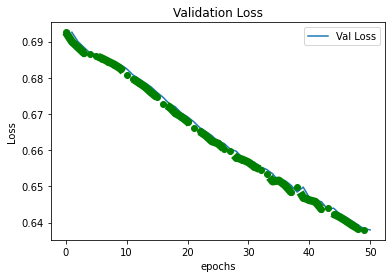

In [19]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, val_losses, label='Val Loss')
  
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title("Validation Loss")
  
plt.plot(val_losses, 'o:g', linestyle='--', linewidth='8')
  
plt.legend()
plt.show()

In [20]:
def evaluate(prediction_dataloader, model, model_name, path_to_model, load = False):
    # Prediction on test set
    if load:
        print("Loading the weights of the model...")
        model.load_state_dict(torch.load(path_to_model))

    print('Evaluating on the testset')

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions, true_labels = [], []

    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_t_inputs, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_t_inputs)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        # Store predictions and true labels
        predictions.extend(pred_flat)
        true_labels.extend(labels_flat)
    # Code for result display
    print(model_name, 'Image Only ResNet Classification accuracy is')
    print(metrics.accuracy_score(true_labels, predictions)*100)
    print(classification_report(true_labels, predictions, target_names = ['fake', 'real']))
	# For error analysis
    new_df = pd.DataFrame()
    new_df['ids'], new_df['ground_truth'], new_df['predicted'] = test_ids, true_labels, predictions
    new_df.to_csv(str('error_analysis/'+model_name+'.csv'), index=False)  
	# Converting to csv
	# Removed transpose - check if actually required
    clsf_report = pd.DataFrame(classification_report(y_true = true_labels, y_pred = predictions, output_dict=True, target_names = ['fake', 'real']))
    clsf_report.to_csv(str('saved_models/'+model_name+'.csv'), index= True)

In [21]:
model_name = 'image_only_resnet'
path_to_model = 'saved_models/class_contrast_visualbert_lr_3e-05_val_loss_0.35285_ep_100.pt'
evaluate(test_dataloader, model, model_name, path_to_model = path_to_model, load = False)

Evaluating on the testset
image_only_resnet Image Only ResNet Classification accuracy is
61.80968564146134
              precision    recall  f1-score   support

        fake       0.61      0.35      0.44      1031
        real       0.62      0.83      0.71      1323

    accuracy                           0.62      2354
   macro avg       0.62      0.59      0.58      2354
weighted avg       0.62      0.62      0.59      2354

